In [1]:
# Note by XO on 04/13/2022: This is an HDBSCAN clustering result analysis script. 
# We calculate the Jaccard similarity coefficients to identify similar clusters to the baseline 
# clusters. The distribution of the coefficients is examined to determine the appropriate
# cut for picking out similar clusters.
# The sample studied here are de-noised stacked sample.
# Import libraries
import glob
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Ellipse
from matplotlib.colors import ListedColormap, Normalize, LogNorm
from scipy.interpolate import interpn
import seaborn as sns

cmap = ListedColormap(sns.color_palette("colorblind",256))
pal = sns.color_palette('colorblind', 256)

# import astropy.coordinates as coord
# import astropy.units as u

label_size = 24
matplotlib.rc('font', size=label_size) 

# import sklearn
# # print(sklearn.__version__)
# from sklearn.mixture import GaussianMixture
# from sklearn.cluster import DBSCAN
# from sklearn.cluster import OPTICS
# from sklearn.cluster import AgglomerativeClustering
# from sklearn import metrics
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import RobustScaler
# from sklearn.decomposition import PCA
# import hdbscan

import warnings
warnings.filterwarnings("once")

In [2]:
# Define a function to plot the clusters means
def plot_clusters(means, dispersions, x_label, y_label, xlim_l, xlim_u, ylim_l, ylim_u, c_list,
                  add_data=[], add_err=[], add_c_list=[],
                  fig_size = [4,1], n_dim = 3, n_row = 1, n_col = 3, 
                  x_ax = [0,0,2], y_ax = [1,2,1], 
                  err_bar = True, f_name=None):
    assert (len(means[0]) == len(dispersions[0])) and (len(means[0]) == len(x_label)) and (len(y_label) == len(x_label))
    
    f = plt.figure(figsize=fig_size)
    
    for i in range(n_row):
        for j in range(n_col):
            k = i*n_col+j
            plt.subplot(n_row, n_col, k+1)
            if err_bar == True:
                plt.errorbar(x=means[:,x_ax[k]], y=means[:,y_ax[k]], xerr=dispersions[:,x_ax[k]], yerr=dispersions[:,y_ax[k]],
                             linestyle='none',c=c_list,markersize=10)
                if len(add_data) != 0 and len(add_err) != 0:
                    plt.errorbar(x=add_data[:,x_ax[k]], y=add_data[:,y_ax[k]], xerr=add_err[:,x_ax[k]], yerr=add_err[:,y_ax[k]],
                                 linestyle='none',c=add_c_list,markersize=5)
                elif len(add_data) != 0 and len(add_err) == 0: 
                    plt.scatter(x=add_data[:,x_ax[k]], y=add_data[:,y_ax[k]],c=add_c_list,s=5)
            else:
                plt.scatter(x=means[:,x_ax[k]], y=means[:,y_ax[k]],c=c_list,s=10)
                if len(add_data) != 0:
                    plt.scatter(x=add_data[:,x_ax[k]], y=add_data[:,y_ax[k]],c=add_c_list,s=5)
                
            plt.xlabel(x_label[k])
            plt.ylabel(y_label[k])
            plt.xlim([xlim_l[k],xlim_u[k]])
            plt.ylim([ylim_l[k],ylim_u[k]])
    
    plt.tight_layout()
    
    if f_name != None:
        f.savefig(f_name)
    
    plt.show()

In [3]:
# Define a function to calculate the Jaccard coefficient for any two given clusters mask
def calc_jacc(clust_mask_1, clust_mask_2, nstar_1 = None, nstar_2 = None, base=1):
    '''
    Calculate the Jaccard coefficient between two given clusters;
    Assume cluster 1 is the baseline cluster by default;
    '''
    
    # Calculate the total number of stars in each cluster if not given
    if (nstar_1 == None) or (nstar_2 == None):
        nstar_1, nstar_2 = len(clust_mask_1), len(clust_mask_2)
    else:
        assert (nstar_1 == len(clust_mask_1)) and (nstar_2 == len(clust_mask_2))
    
    # Find the intersection between two clusters
    clust_common = np.intersect1d(clust_mask_1,clust_mask_2,assume_unique=True)
    nstar_common = len(clust_common)
    
    # Return the Jaccard coeff; as well as the "inversed" Jaccard coeff (as if the other cluster is the base)
    if base == 1:
        return nstar_common/nstar_1, nstar_common/nstar_2
    elif base == 2:
        return nstar_common/nstar_2, nstar_common/nstar_1

In [15]:
# Import data of results from the random resampling clustering
# space = 'E_act'
# space_e = 'act_etot'
space = 'vel_cyl'
space_e = 'vel_cyl'
cut = '2500'
pcut = '10'


data_dir = './' + space + '_' + cut + '_data_20_20_err_nocut/'
extratext = '_0412_Nstackcut_' + pcut + '_' + space_e + '_hdbscan_min_samples_20_min_clustsize_20_leaf_samp_'

# cluster_id = np.load(data_dir + 'member_gedr3id' + extratext + '.npy',allow_pickle=True)
# cluster_ind = np.load(data_dir + 'member_mask' + extratext + '.npy',allow_pickle=True)
# cluster_col = np.load(data_dir + 'color' + extratext + '.npy',allow_pickle=True)
# cluster_nstar = np.load(data_dir + 'member_nstar' + extratext + '.npy',allow_pickle=True)
# cluster_means = np.load(data_dir + 'member_means' + extratext + '.npy',allow_pickle=True)
# cluster_dispersions = np.load(data_dir + 'member_disps' + extratext + '.npy',allow_pickle=True)

N_samp = 100

# Find all the files
samp_list = np.arange(N_samp,dtype=int)
mean_path_list = []
disp_path_list = []
nstar_path_list = []
mask_path_list = []


for i in range(N_samp):
    mask_file_name = glob.glob(data_dir+'member_mask'+ extratext + str(samp_list[i])+'.npy')[0]
    mean_file_name = glob.glob(data_dir+'member_means'+ extratext + str(samp_list[i])+'.npy')[0]
    disp_file_name = glob.glob(data_dir+'member_disps'+ extratext + str(samp_list[i])+'.npy')[0]
    nstar_file_name = glob.glob(data_dir+'member_nstar'+ extratext + str(samp_list[i])+'.npy')[0]
    mask_path_list.append(mask_file_name)
    mean_path_list.append(mean_file_name)
    disp_path_list.append(disp_file_name)
    nstar_path_list.append(nstar_file_name)

N_files = len(mean_path_list)


# Import files into arrays
mask_result_list = []
mean_result_list = []
disp_result_list = []
nstar_result_list = []


for i in range(0,N_files):
#     print('Appending file #',i)
    mask_result_list.append(np.load(mask_path_list[i],allow_pickle=True))
    mean_result_list.append(np.load(mean_path_list[i],allow_pickle=True))
    disp_result_list.append(np.load(disp_path_list[i],allow_pickle=True))
    nstar_result_list.append(np.load(nstar_path_list[i],allow_pickle=True))
#     print(len(mean_result_list[i]),len(disp_result_list[i]),len(nstar_result_list[i]))
    
# Examine the seeds
seed_rand_arr = np.load(data_dir+'random_seed'+extratext[:-6]+'.npy')
print(seed_rand_arr)

# Combine the data and get rid of the zero star clusters (from default prepared arrays)

# Count the number of cluster in each trial
nclu_arr = np.zeros(N_samp,dtype=int)
for i in range(N_samp):
    nclu = len(np.where(nstar_result_list[i] != 0)[0])-1
    nclu_arr[i] = nclu


# print(nclu_arr)

# Pick out the cluster means and dispersions
mask_comb = mask_result_list[0][0:nclu_arr[0]]
mean_comb = mean_result_list[0][0:nclu_arr[0]]
disp_comb = disp_result_list[0][0:nclu_arr[0]]
nstar_comb = nstar_result_list[0][0:nclu_arr[0]]

# Also create a label for identifying which trial each cluster came from
clust_lbl_comb = [0]*nclu_arr[0]

for i in range(1,N_samp):
    mask_comb = np.concatenate((mask_comb,mask_result_list[i][0:nclu_arr[i]]))
    mean_comb = np.vstack((mean_comb,mean_result_list[i][0:nclu_arr[i]]))
    disp_comb = np.vstack((disp_comb,disp_result_list[i][0:nclu_arr[i]]))
    nstar_comb = np.concatenate((nstar_comb,nstar_result_list[i][0:nclu_arr[i]]))
    clust_lbl_comb = clust_lbl_comb+[i]*nclu_arr[i]

clust_lbl_comb = np.array(clust_lbl_comb)
# Count total number of cluster
print("Total number of clusters across",N_samp,"realizations is",len(mask_comb),len(mean_comb),len(disp_comb),len(nstar_comb),len(clust_lbl_comb))

[6252 4684 1731 4742 4521 6340  576 5202 6363  439 2750 7487 5272 5653
 3999 6033  582 9930 7051 8158 9896 2249 4640 9485 4947 9920 1963 8243
 6590 8847  321 2678 4625 4949 8328 3337 5589  251 3973 6630 5547   35
 8362 1513 9317   39 4819 3465 1760 2304 3723 8284 4993 8127 3032 7938
 3039 9655 2545 2592 1188 7966 6077  107 1315 8187 2753 9753 6231 2876
 5323  799 3570 2894 2927 8178  971 6687 8575 2020 9054  952 5359 3857
 5861 3145 3305 3006 9001 7770 7438 7942 9238 1056 3154 3787 9189 7825
 7539 7231]
Total number of clusters across 100 realizations is 2786 2786 2786 2786 2786


In [16]:
# Import the baseline clustering result

# Use old result here since they are the same depending on which random sampling we are using
# data_dir = './vel_cyl_2500_data_15_40/'
# extratext = '_0119_g2only_err_vel_cyl2500_hdbscan_min_samples_15_min_clustsize_40_leaf_samp_'

id_base = np.load(data_dir + 'member_gedr3id' + extratext[:-6] + '_baseline.npy',allow_pickle=True)
mask_base = np.load(data_dir + 'member_mask' + extratext[:-6] + '_baseline.npy',allow_pickle=True)
col_base = np.load(data_dir + 'color' + extratext[:-6] + '_baseline.npy',allow_pickle=True)
nstar_base = np.load(data_dir + 'member_nstar' + extratext[:-6] + '_baseline.npy',allow_pickle=True)
# Didn't have nstar exported; calculate one from the id_base
# nstar_base = [len(clust) for clust in id_base]
# mean_base = np.load(data_dir + 'member_means' + extratext[:-6] + '_baseline.npy',allow_pickle=True)
# disp_base = np.load(data_dir + 'member_disps' + extratext[:-6] + '_baseline.npy',allow_pickle=True)

In [17]:
print([int(nstar) for nstar in nstar_base])

[63, 28, 49, 77, 53, 35, 57, 82, 27, 95, 46, 22, 26, 50, 31, 199, 43, 39, 43, 118, 26, 24, 189, 106, 30, 21, 21, 44, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1271]


In [18]:
np.shape(mask_base)

(29,)

In [19]:
# plot_dir = './' + space + '_' + cut + '_plot_20_20_err_abs/'
plot_dir = './' + space + '_' + cut + '_plot_20_20_err_nocut/'

In [20]:
# For a given baseline cluster; loop through all the sampling clusters and calculate the Jaccard coefficient
jacc_coef = []
inv_jacc_coef = []

for i in range(len(mask_base)-1):
    mask_base_i = mask_base[i]
    nstar_base_i = nstar_base[i]
    jacc_coef_i = np.zeros(len(mask_comb))
    inv_jacc_coef_i = np.zeros(len(mask_comb))
    
    for j in range(len(mask_comb)):
        jacc_coef_i[j], inv_jacc_coef_i[j] = calc_jacc(mask_base_i, mask_comb[j],nstar_1=nstar_base_i,nstar_2=nstar_comb[j])
        
    jacc_coef.append(jacc_coef_i)
    inv_jacc_coef.append(inv_jacc_coef_i)

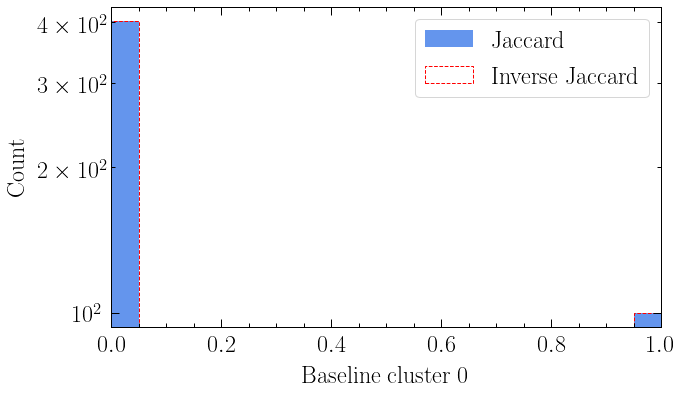

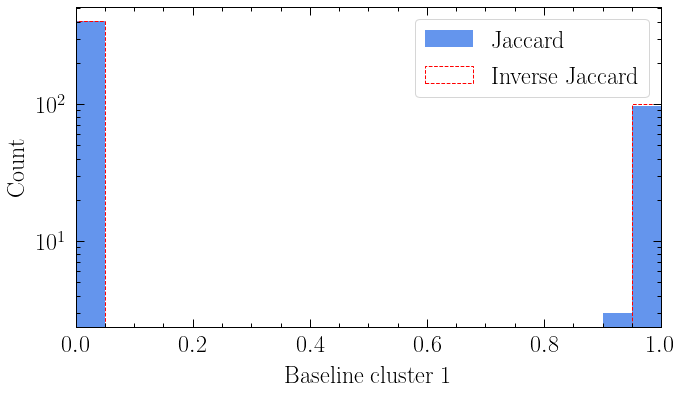

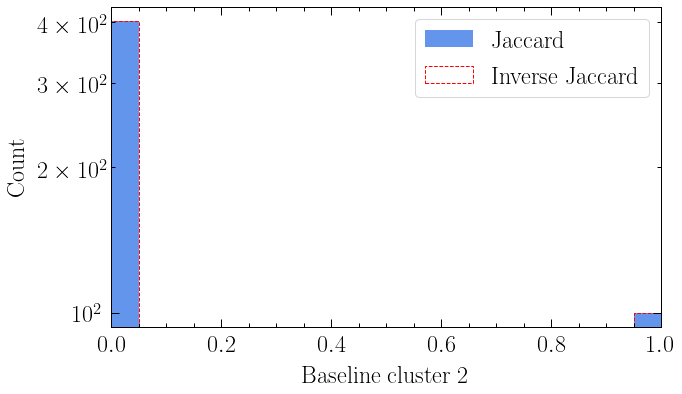

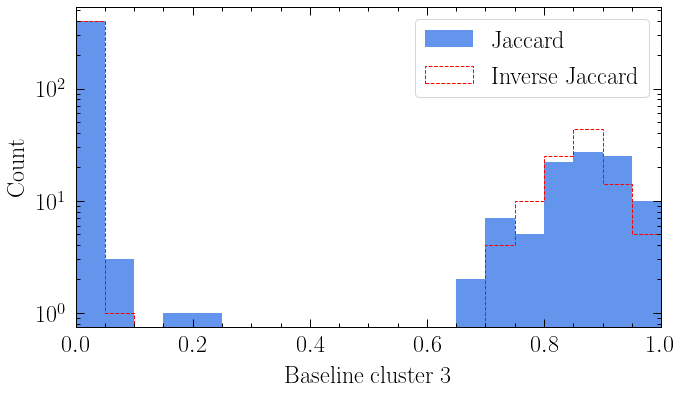

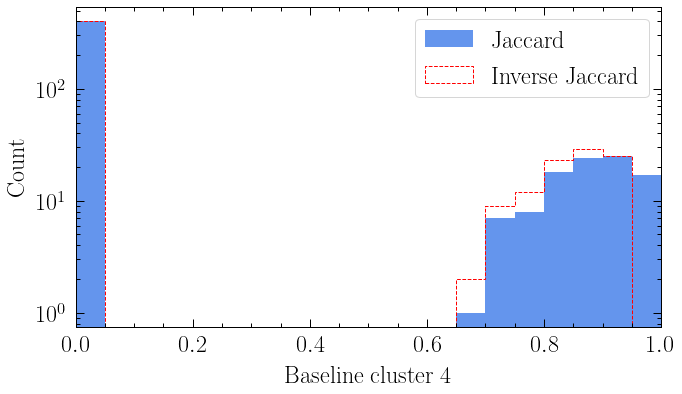

In [225]:
# look at the Jaccard coeffecient distribution
for i in range(len(jacc_coef)):
    f = plt.figure(figsize=[10,6])

    plt.hist(jacc_coef[i],bins=np.linspace(0.,1.,21),histtype='stepfilled',label='Jaccard')
    plt.hist(inv_jacc_coef[i],bins=np.linspace(0.,1.,21),histtype='step',label='Inverse Jaccard',ls='--',color='red')
    plt.xlabel('Baseline cluster '+str(i))
    plt.ylabel('Count')
    plt.xlim([0,1])
    plt.yscale('log')
    plt.legend()

    plt.tight_layout()
    plt.show()
#     f.savefig(plot_dir + 'jacc_distribution_for_cluster_' + str(i) + '.pdf')

In [21]:
jacc_coef = np.array(jacc_coef)
inv_jacc_coef = np.array(inv_jacc_coef)

In [22]:
ind_tmp = np.where(clust_lbl_comb == 1)[0]
print(np.argmax(jacc_coef[0][ind_tmp]))
# len(jacc_coef[0])

0


In [23]:
# Within each realization, pick out the cluster with the highest JC for a given baseline cluster 
jacc_coef_max = np.zeros((len(jacc_coef),N_samp))
inv_jacc_coef_max = np.zeros((len(jacc_coef),N_samp))  # Note this is the inverse JC corresponding to the highest JC, not the highest inver JC
clust_ind_jacc_max = np.zeros((len(jacc_coef),N_samp)) # The cluster id from each realization that has the highest JC


for i in range(len(jacc_coef)):
    for j in range(N_samp):
        # Limit the range to that of a particular trial
        ind_tmp = np.where(clust_lbl_comb == j)[0]
        jacc_coef_max[i,j] = np.max(jacc_coef[i][ind_tmp])
        # If there not a single cluster from the realization that's remotely similar to the baseline
        # set the correponding max JC index to -1
        if jacc_coef_max[i,j] < 1e-6: # Arbitrarily set a lower limit for JC
            max_ind_tmp = -1
            inv_jacc_coef_max[i,j] = 0
        else:
            max_ind_tmp = np.argmax(jacc_coef[i][ind_tmp])
            inv_jacc_coef_max[i,j] = inv_jacc_coef[i][ind_tmp[max_ind_tmp]]
        clust_ind_jacc_max[i,j] = max_ind_tmp

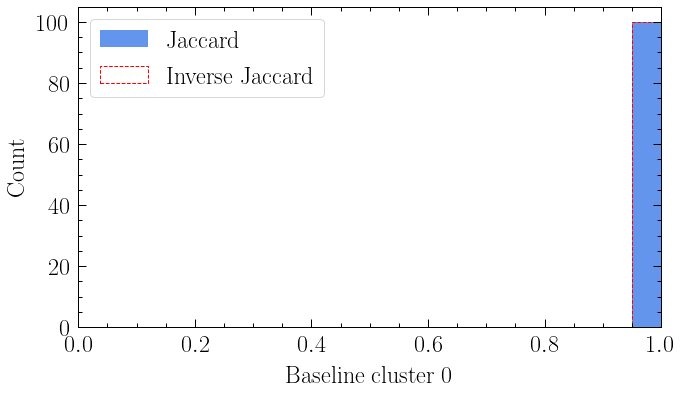

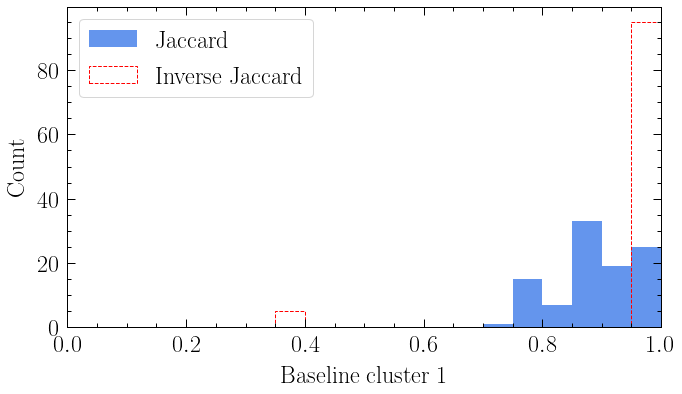

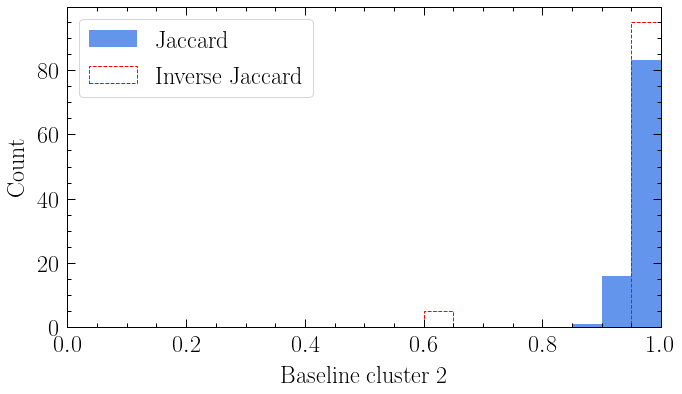

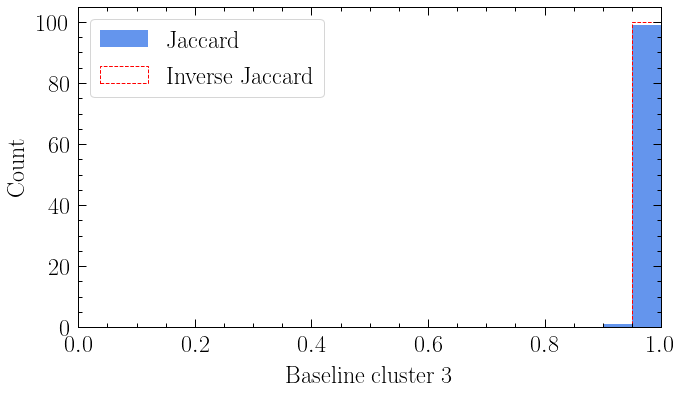

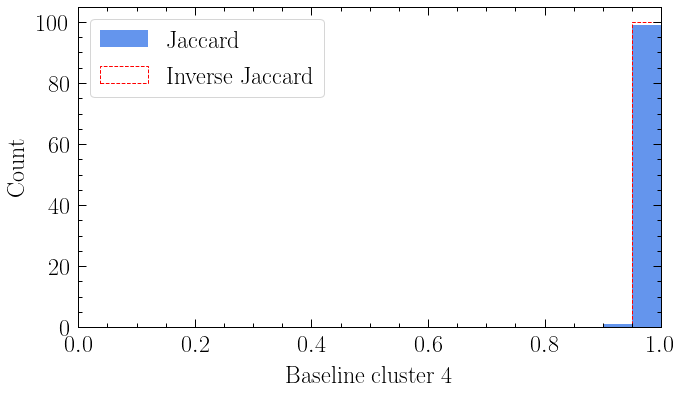

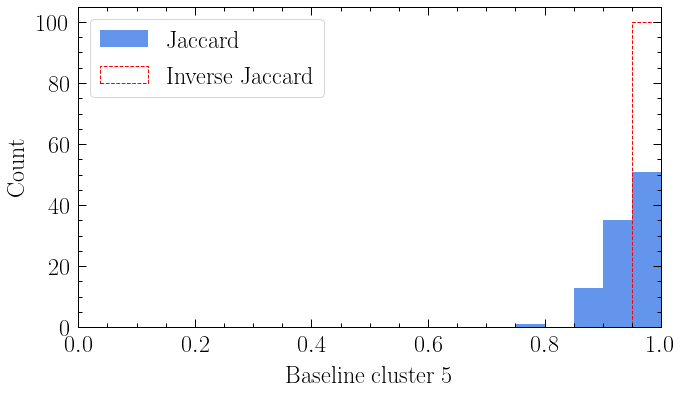

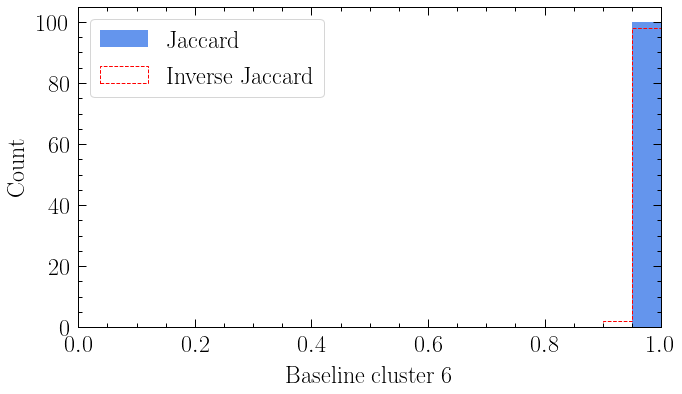

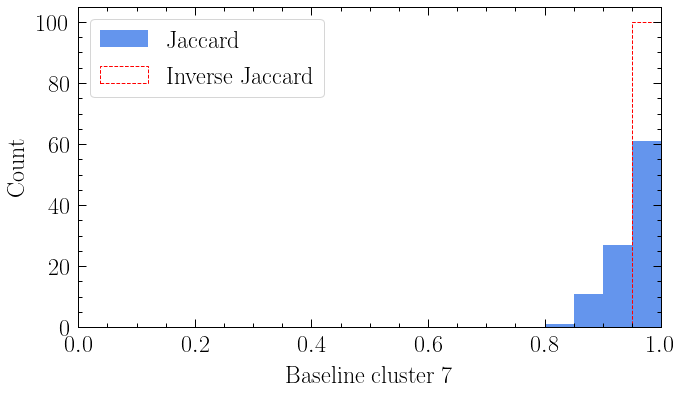

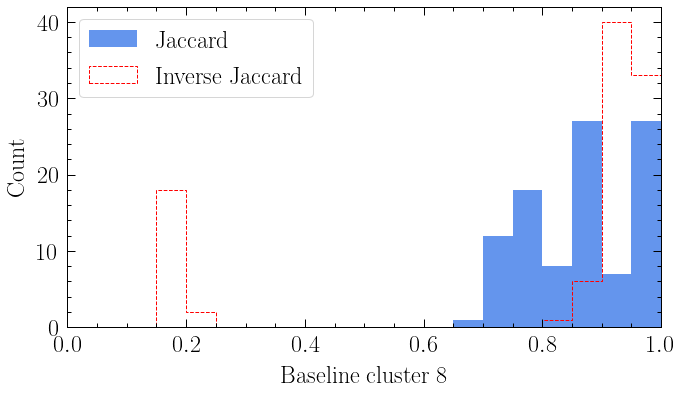

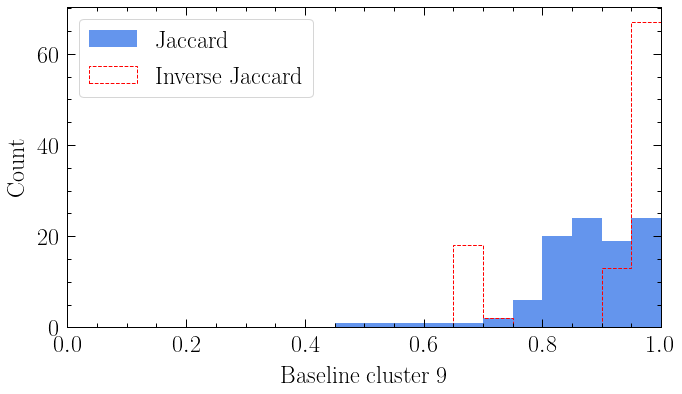

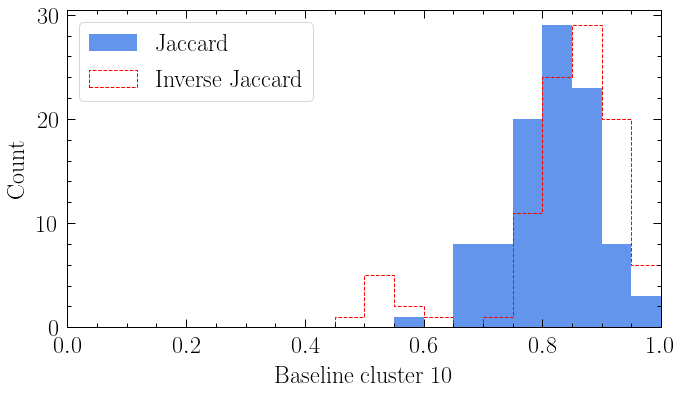

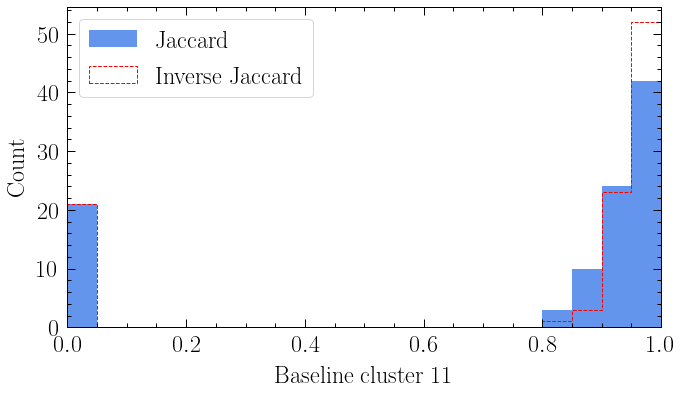

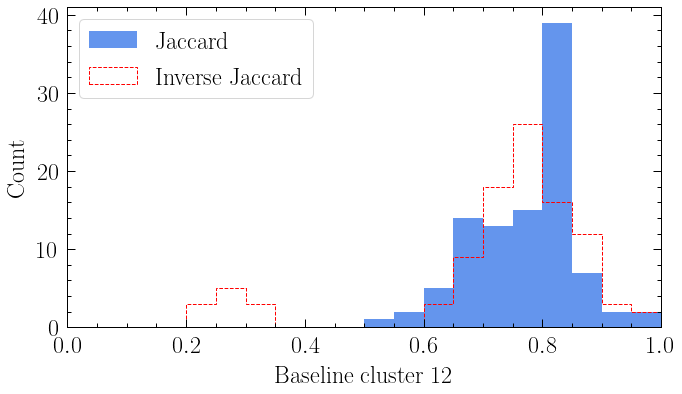

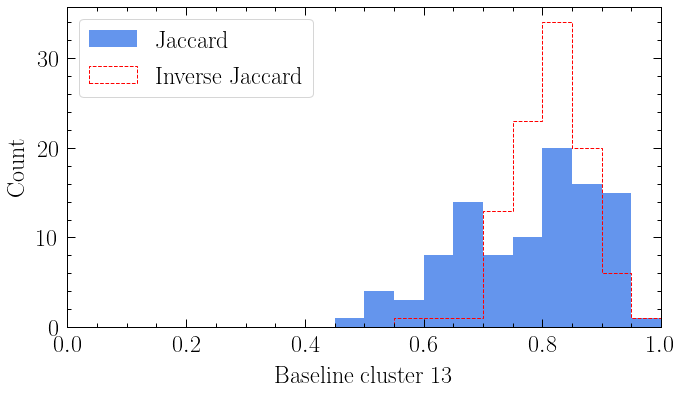

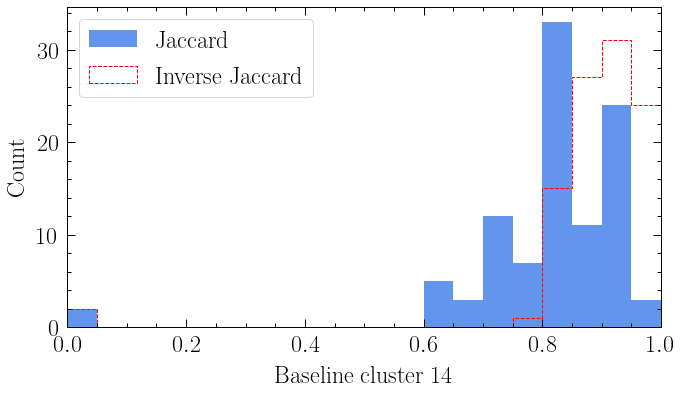

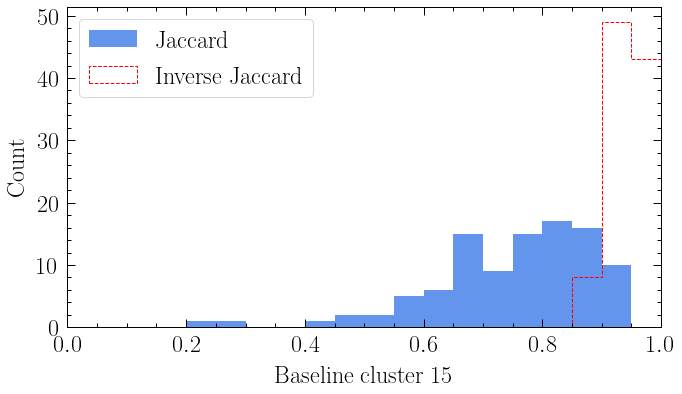

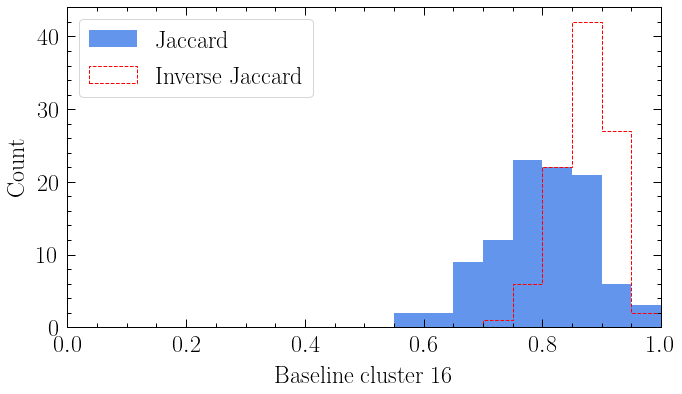

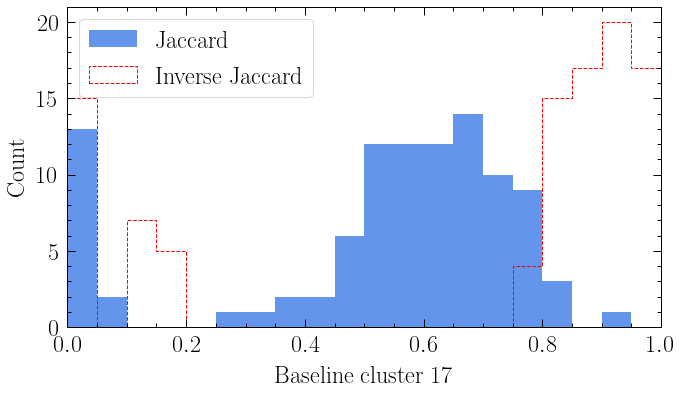

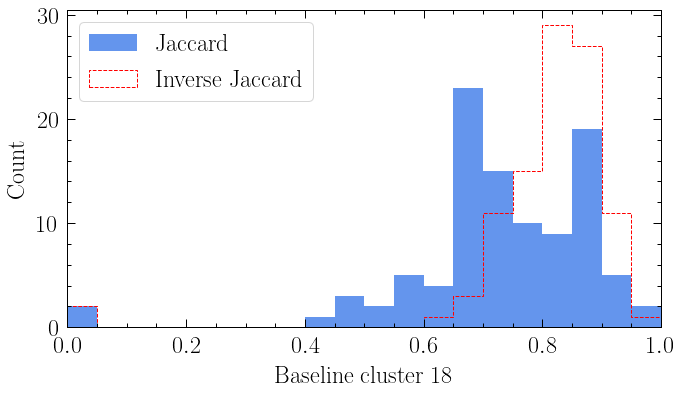

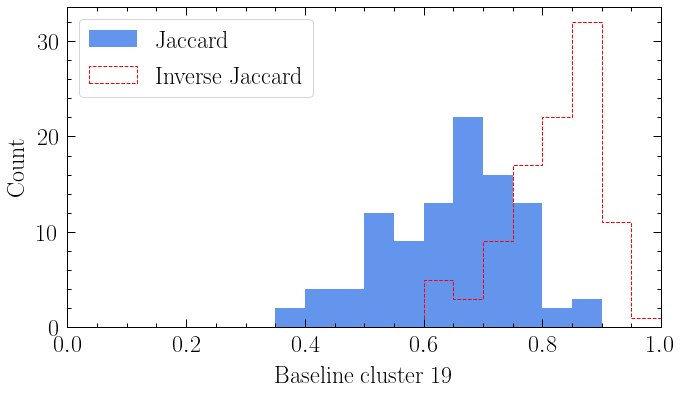

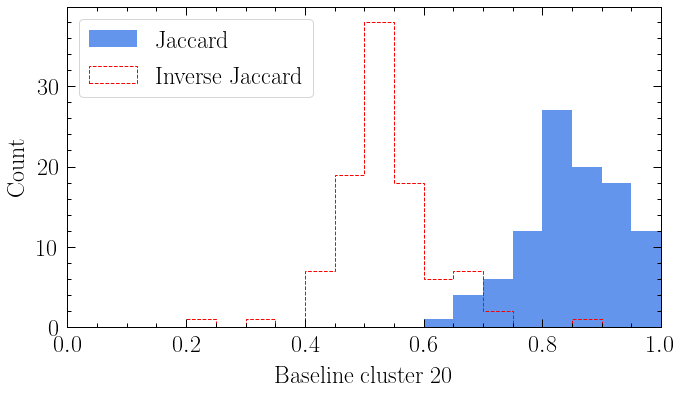

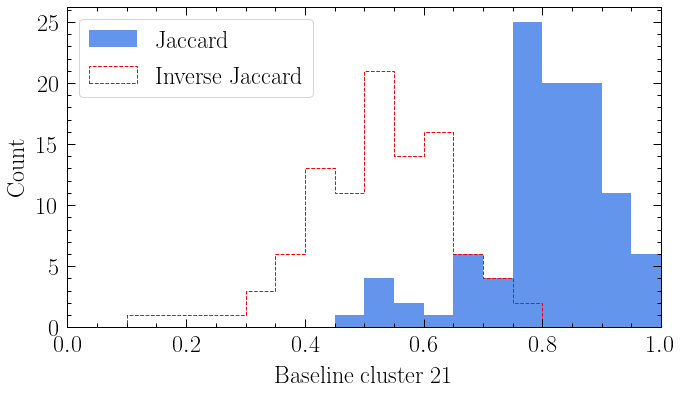

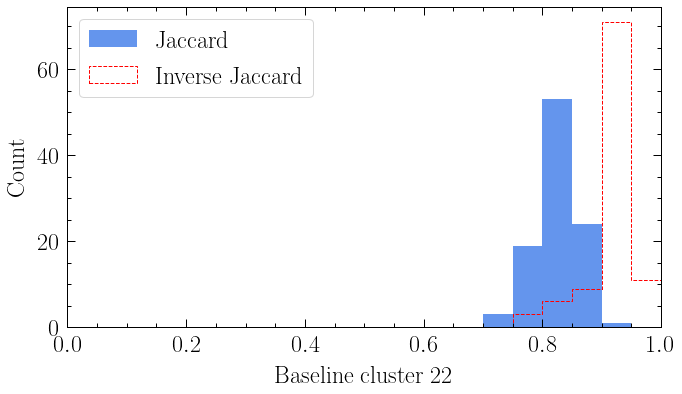

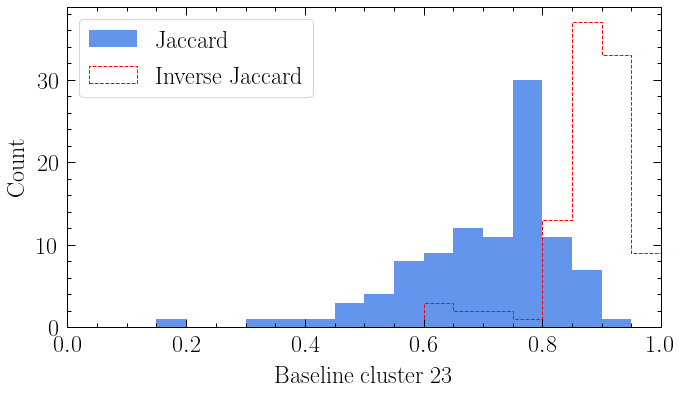

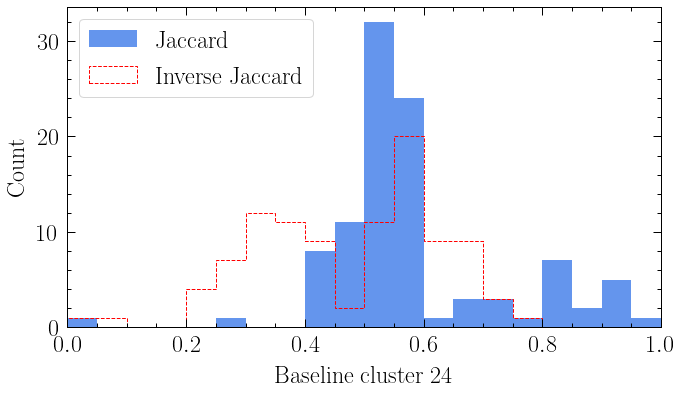

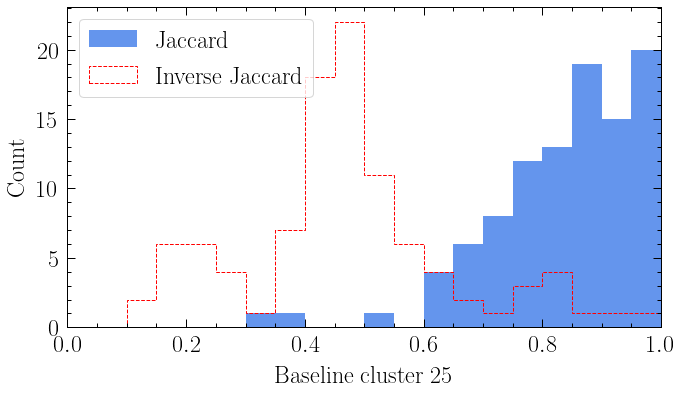

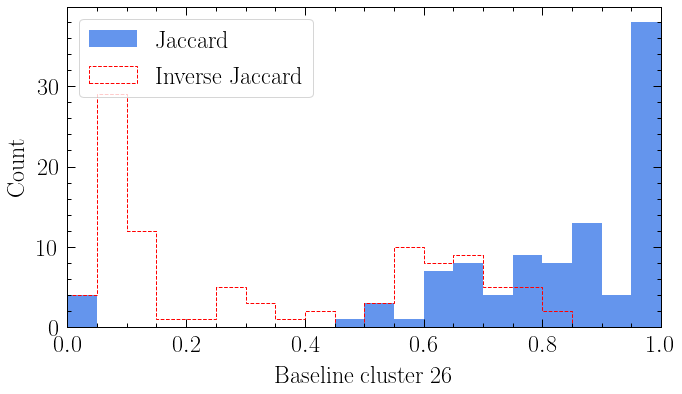

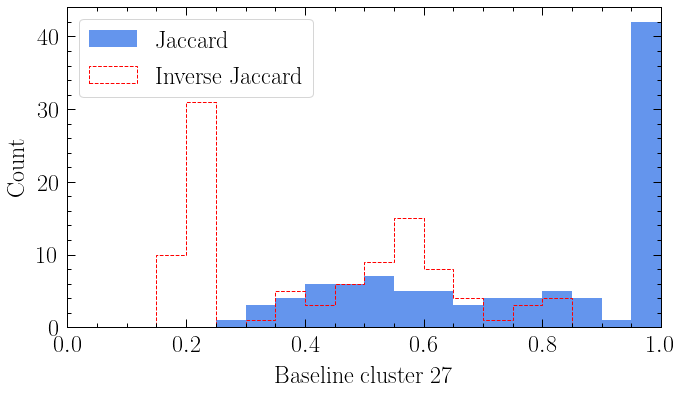

In [24]:
# Plot the distribution of the highest JCs
for i in range(len(jacc_coef)):
    f = plt.figure(figsize=[10,6])

    plt.hist(jacc_coef_max[i],bins=np.linspace(0.,1.,21),histtype='stepfilled',label='Jaccard')
    plt.hist(inv_jacc_coef_max[i],bins=np.linspace(0.,1.,21),histtype='step',label='Inverse Jaccard',ls='--',color='red')
    plt.xlabel('Baseline cluster '+str(i))
    plt.ylabel('Count')
    plt.xlim([0,1])
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()
#     f.savefig(plot_dir + 'max_jacc_distribution_for_cluster_' + str(i) + '.pdf')

In [117]:
print(jacc_coef_max[:,0],clust_ind_jacc_max[:,0])

[1.         0.75789474 0.83333333 0.8372093  0.8375     0.51666667
 0.86842105 0.82894737 0.90243902 0.89285714] [0. 1. 4. 3. 2. 7. 5. 6. 7. 7.]


In [118]:
# Count how many times a random realization cluster provide the highest JC for a baseline cluster
from collections import Counter


for i in range(N_samp-90):
    print('Counting random realization:',i)
    # Get rid of the clusters that didn't find a match
    ind_match_tmp = (clust_ind_jacc_max[:,i] > -0.5)
    count_res = Counter(clust_ind_jacc_max[:,i][ind_match_tmp])
    for j in range(len(count_res.most_common())):
        if count_res.most_common()[j][1] > 1.5:
            clut_repeat_ind_tmp = count_res.most_common()[j][0]
            # Search which baseline clusters shared the same random realization cluster
            base_share_ind = np.where(clust_ind_jacc_max[:,i] == clut_repeat_ind_tmp)[0]
            print("Baseline clusters:",base_share_ind,"shared the same highest JC cluster", clut_repeat_ind_tmp ," in this realization.")
            print("This random cluster gives JC:",jacc_coef_max[:,i][base_share_ind],"respectively for these baseline clusters.")
            print("This random cluster gives inverse JC:",inv_jacc_coef_max[:,i][base_share_ind],"respectively for these baseline clusters.")

Counting random realization: 0
Baseline clusters: [5 8 9] shared the same highest JC cluster 7.0  in this realization.
This random cluster gives JC: [0.51666667 0.90243902 0.89285714] respectively for these baseline clusters.
This random cluster gives inverse JC: [0.20529801 0.24503311 0.16556291] respectively for these baseline clusters.
Counting random realization: 1
Counting random realization: 2
Baseline clusters: [8 9] shared the same highest JC cluster 8.0  in this realization.
This random cluster gives JC: [0.90243902 0.75      ] respectively for these baseline clusters.
This random cluster gives inverse JC: [0.31623932 0.17948718] respectively for these baseline clusters.
Counting random realization: 3
Counting random realization: 4
Baseline clusters: [8 9] shared the same highest JC cluster 8.0  in this realization.
This random cluster gives JC: [0.90243902 0.85714286] respectively for these baseline clusters.
This random cluster gives inverse JC: [0.30578512 0.19834711] respe

In [119]:
# Count how many times a random realization cluster provide the highest JC for a baseline cluster and output the result into a text file
f = open(plot_dir+'JC_failure_mode.txt','w')
for i in range(N_samp):
    print('Counting random realization:'+str(i),file=f)
    # Get rid of the clusters that didn't find a match
    ind_match_tmp = (clust_ind_jacc_max[:,i] > -0.5)
    count_res = Counter(clust_ind_jacc_max[:,i][ind_match_tmp])
    for j in range(len(count_res.most_common())):
        if count_res.most_common()[j][1] > 1.5:
            clut_repeat_ind_tmp = count_res.most_common()[j][0]
            # Search which baseline clusters shared the same random realization cluster
            base_share_ind = np.where(clust_ind_jacc_max[:,i] == clut_repeat_ind_tmp)[0]
            print("Baseline clusters:",base_share_ind,"shared the same highest JC cluster", clut_repeat_ind_tmp ," in this realization.",file=f)
            print("This random cluster gives JC:",jacc_coef_max[:,i][base_share_ind],"respectively for these baseline clusters.",file=f)
            print("This random cluster gives inverse JC:",inv_jacc_coef_max[:,i][base_share_ind],"respectively for these baseline clusters.",file=f)
            
f.close()

In [ ]:
# Note: this loop only picks out the random cluster that gives the second many most highest JC from each realization
# It's not guaranteed that there aren't more random clusters giving multiple highest JC
for i in range(N_samp-90):
    print('Counting random realization:',i)
    # Get rid of the clusters that didn't find a match
    ind_match_tmp = (clust_ind_jacc_max[:,i] > -0.5)
    count_res = Counter(clust_ind_jacc_max[:,i][ind_match_tmp])
    if count_res.most_common(2)[1][1] > 1.5:
        clut_repeat_ind_tmp = count_res.most_common(2)[1][0]
        # Search which baseline clusters shared the same random realization cluster
        base_share_ind = np.where(clust_ind_jacc_max[:,i] == clut_repeat_ind_tmp)[0]
        print("Baseline clusters:",base_share_ind,"shared the same highest JC cluster", clut_repeat_ind_tmp ," in this realization.")
        print("This random cluster gives JC:",jacc_coef_max[:,i][base_share_ind],"respectively for these baseline clusters.")
        print("This random cluster gives inverse JC:",inv_jacc_coef_max[:,i][base_share_ind],"respectively for these baseline clusters.")

In [120]:
np.shape(jacc_coef_max)

(10, 100)

In [121]:
int(clut_repeat_ind_tmp)

8

In [122]:
# Only plot the random sample clusters without any repeated highest JC issue
clust_ind_no_issue_w_cut = []
base_ind_no_issue_w_cut = []

for i in range(N_samp):
#     print('Counting random realization:',i)
    # Generate an index list for the current realization
    ind_list_i = np.where(clust_lbl_comb == i)[0]
    # Get rid of the clusters that didn't find a match
    ind_match_tmp = (clust_ind_jacc_max[:,i] > -0.5)
    count_res = Counter(clust_ind_jacc_max[:,i][ind_match_tmp])
#     print(count_res)
    for j in range(len(count_res.most_common())):
        if count_res.most_common()[j][1] < 1.5:
            clut_ok_ind_tmp_i = int(count_res.most_common()[j][0])
            clut_ok_ind_tmp_all = ind_list_i[clut_ok_ind_tmp_i]
#             print(clut_ok_ind_tmp_all)
            base_ok_ind = np.where(clust_ind_jacc_max[:,i] == clut_ok_ind_tmp_i)[0][0]
            if jacc_coef_max[base_ok_ind,i] > 0.5:
                clust_ind_no_issue_w_cut.append(clut_ok_ind_tmp_all)
                base_ind_no_issue_w_cut.append(base_ok_ind)
            
print(clust_ind_no_issue_w_cut,base_ind_no_issue_w_cut)
print(len(clust_ind_no_issue_w_cut))

[0, 1, 4, 3, 2, 5, 6, 8, 9, 12, 11, 10, 14, 15, 17, 16, 18, 19, 20, 21, 22, 23, 25, 27, 28, 32, 31, 30, 34, 35, 37, 36, 38, 39, 42, 41, 40, 43, 47, 48, 49, 51, 52, 50, 53, 55, 57, 56, 58, 59, 62, 61, 60, 63, 65, 67, 68, 69, 70, 72, 71, 75, 77, 78, 80, 83, 82, 81, 84, 87, 86, 88, 89, 92, 90, 94, 93, 95, 97, 98, 99, 101, 100, 102, 104, 105, 106, 107, 108, 112, 111, 110, 115, 116, 117, 119, 120, 121, 124, 127, 128, 129, 132, 131, 130, 134, 135, 138, 139, 141, 142, 140, 145, 146, 148, 149, 154, 155, 156, 157, 159, 158, 160, 161, 165, 164, 166, 168, 169, 171, 172, 175, 174, 173, 176, 177, 178, 179, 180, 181, 182, 183, 188, 187, 189, 191, 192, 193, 194, 195, 198, 199, 200, 201, 202, 203, 207, 206, 204, 208, 209, 211, 212, 217, 216, 214, 218, 215, 220, 221, 222, 224, 225, 223, 228, 227, 229, 230, 231, 232, 233, 235, 236, 234, 237, 239, 240, 241, 242, 247, 246, 245, 249, 248, 251, 252, 250, 253, 254, 257, 255, 256, 258, 259, 260, 262, 263, 266, 265, 264, 269, 270, 272, 271, 273, 274, 277, 278,

In [123]:
# Remove the ones that doesn't provide JC higher than 0.5 more than 70 times
clust_ind_no_issue_w_cut_plus_70 = []
count_res = Counter(base_ind_no_issue_w_cut)
print(count_res)
for i in range(len(count_res.most_common())):
    if count_res.most_common()[i][1] > 70:
        base_ok_ind_tmp = int(count_res.most_common()[i][0])
        clust_ok_ind = list(np.where(np.array(base_ind_no_issue_w_cut) == base_ok_ind_tmp)[0])
        clust_ind_no_issue_w_cut_plus_70 += list(np.array(clust_ind_no_issue_w_cut)[clust_ok_ind])

print(np.array(clust_ind_no_issue_w_cut_plus_70))

Counter({0: 100, 6: 99, 7: 96, 2: 93, 1: 90, 4: 89, 3: 78, 8: 68, 9: 61, 5: 30})
[   0    8   18   27   38   48   58   68   78   88   97  107  119  128
  138  148  160  171  181  191  202  211  221  232  242  253  262  273
  284  295  307  317  329  340  350  361  371  383  395  406  417  428
  437  447  456  465  475  487  497  508  520  531  540  550  561  572
  582  594  605  616  628  639  650  660  668  678  687  698  710  721
  733  743  754  765  776  788  799  809  819  828  838  848  859  870
  880  890  900  909  919  930  941  950  960  970  980  990 1000 1012
 1021 1032    5   14   23   34   43   53   63   75   87   93  102  115
  124  134  145  156  166  177  187  198  208  215  227  237  248  259
  269  279  291  303  312  325  334  346  357  366  379  389  401  413
  424  433  442  452  461  469  483  493  504  516  526  536  546  555
  569  577  590  600  611  624  637  644  656  664  674  683  692  705
  716  728  739  745  761  772  784  794  805  815  824  833  843  

In [124]:
mean_comb[0]

array([-104.27654188,  293.81307353,  146.19973026])

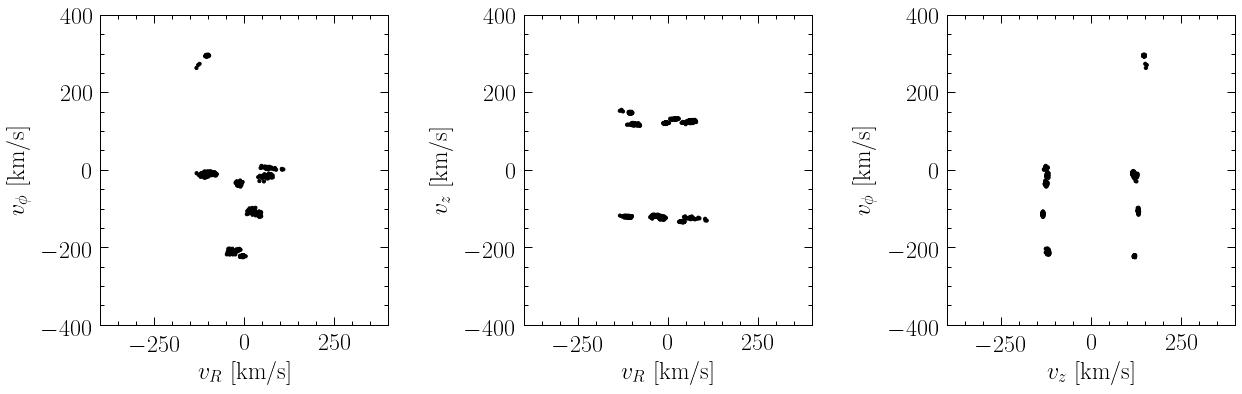

In [125]:
# Make the color list for plotting the clusters that don't have the issue and provide a JC higher than a certain threshold
col_list = np.array([[0.,0.,0.,0.]]*len(mean_comb))
for i in clust_ind_no_issue_w_cut:
    col_list[i,3] = 1.

plot_clusters(mean_comb, disp_comb, 
              x_label=[r'$v_{R}$ [km/s]', r'$v_{R}$ [km/s]', r'$v_{z}$ [km/s]'], 
              y_label=[r'$v_{\phi}$ [km/s]', r'$v_{z}$ [km/s]', r'$v_{\phi}$ [km/s]'], 
              xlim_l=[-400]*3, xlim_u=[400]*3, 
              ylim_l=[-400]*3, ylim_u=[400]*3, 
              fig_size = [18,6], n_dim = 3, n_row = 1, n_col = 3, c_list=col_list,
              x_ax = [0,0,2], y_ax = [1,2,1], 
              err_bar = False, f_name=plot_dir+'cluster_no_fail_JC0p5.pdf')

# plot_clusters(mean_comb, disp_comb, 
#               x_label=[r'$J_{R}$ [kpc km/s]', r'$J_{R}$ [kpc km/s]', r'$J_{\phi}$ [kpc km/s]'], 
#               y_label=[r'$J_{\phi}$ [kpc km/s]', r'$J_{z}$ [kpc km/s]', r'$J_{z}$ [kpc km/s]'], 
#               xlim_l=[0,0,-6000], xlim_u=[10000,10000,6000], 
#               ylim_l=[-6000,0,0], ylim_u=[6000,5000,5000], 
#               fig_size = [18,6], n_dim = 3, n_row = 1, n_col = 3, c_list=col_list,
#               x_ax = [0,0,1], y_ax = [1,2,2], 
#               err_bar = False, f_name=plot_dir+'cluster_no_fail_JC0p5.pdf')

# plot_clusters(mean_comb, disp_comb, 
#               x_label=[r'$L_z$ [kpc km s$^{-1}$]', r'$L_z$ [kpc km s$^{-1}$]', r'$L_{\bot}$ [kpc km s$^{-1}$]'], 
#               y_label=[r'$E_{tot}$ [km$^2$ s$^{-2}$]', r'$L_{\bot}$ [kpc km s$^{-1}$]', r'$E_{tot}$ [km$^2$ s$^{-2}$]'], 
#               xlim_l=[-4500,-4500,-50], xlim_u=[4500,4500,3450], 
#               ylim_l=[-170000,-50,-170000], ylim_u=[10000,3450,10000], 
#               fig_size = [18,6], n_dim = 3, n_row = 1, n_col = 3, c_list=col_list,
#               x_ax = [1,1,2], y_ax = [0,2,0], 
#               err_bar = False, f_name=plot_dir+'cluster_no_fail_JC0p5.pdf')

# plot_clusters(mean_comb, disp_comb, 
#               x_label=[r'$J_{R}$ [kpc km/s]', r'$J_{R}$ [kpc km/s]', r'$J_{\phi}$ [kpc km/s]',r'$L_z$ [kpc km s$^{-1}$]'], 
#               y_label=[r'$J_{\phi}$ [kpc km/s]', r'$J_{z}$ [kpc km/s]', r'$J_{z}$ [kpc km/s]',r'$E_{tot}$ [km$^2$ s$^{-2}$]'], 
#               xlim_l=[0,0,-6000,-4500], xlim_u=[10000,10000,6000,4500], 
#               ylim_l=[-6000,0,0,-170000], ylim_u=[6000,5000,5000,10000], 
#               fig_size = [18,18], n_dim = 4, n_row = 2, n_col = 2, c_list=col_list,
#               x_ax = [0,0,1,1], y_ax = [1,2,2,3], 
#               err_bar = False, f_name=plot_dir+'cluster_no_fail_JC0p5.pdf')

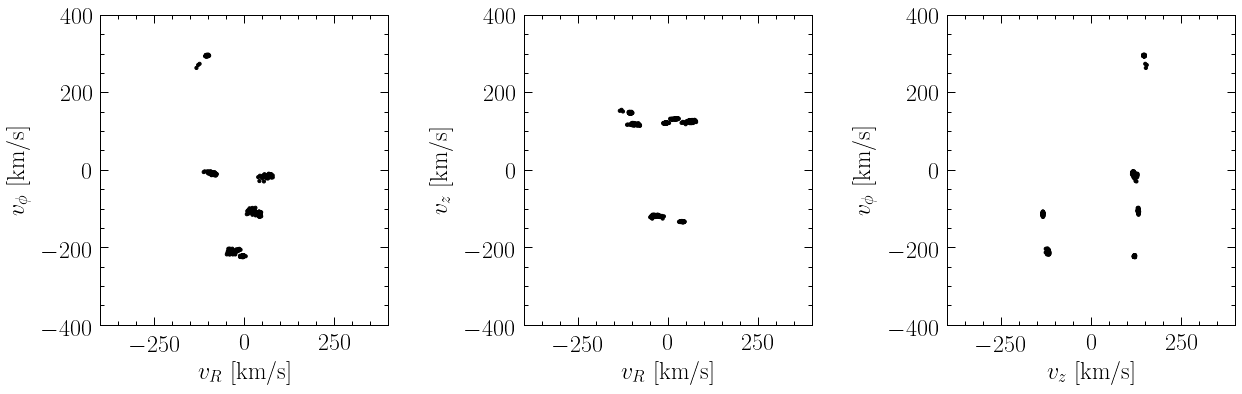

In [126]:
# Make the color list for plotting the clusters that don't have the issue and provide a JC higher than a certain threshold
col_list = np.array([[0.,0.,0.,0.]]*len(mean_comb))
for i in clust_ind_no_issue_w_cut_plus_70:
    col_list[i,3] = 1.

plot_clusters(mean_comb, disp_comb, 
              x_label=[r'$v_{R}$ [km/s]', r'$v_{R}$ [km/s]', r'$v_{z}$ [km/s]'], 
              y_label=[r'$v_{\phi}$ [km/s]', r'$v_{z}$ [km/s]', r'$v_{\phi}$ [km/s]'], 
              xlim_l=[-400]*3, xlim_u=[400]*3, 
              ylim_l=[-400]*3, ylim_u=[400]*3, 
              fig_size = [18,6], n_dim = 3, n_row = 1, n_col = 3, c_list=col_list,
              x_ax = [0,0,2], y_ax = [1,2,1], 
              err_bar = False, f_name=plot_dir+'cluster_no_fail_JC0p5_plus_70.pdf')

# plot_clusters(mean_comb, disp_comb, 
#               x_label=[r'$J_{R}$ [kpc km/s]', r'$J_{R}$ [kpc km/s]', r'$J_{\phi}$ [kpc km/s]'], 
#               y_label=[r'$J_{\phi}$ [kpc km/s]', r'$J_{z}$ [kpc km/s]', r'$J_{z}$ [kpc km/s]'], 
#               xlim_l=[0,0,-6000], xlim_u=[10000,10000,6000], 
#               ylim_l=[-6000,0,0], ylim_u=[6000,5000,5000], 
#               fig_size = [18,6], n_dim = 3, n_row = 1, n_col = 3, c_list=col_list,
#               x_ax = [0,0,1], y_ax = [1,2,2], 
#               err_bar = False, f_name=plot_dir+'cluster_no_fail_JC0p5_plus_70.pdf')

# plot_clusters(mean_comb, disp_comb, 
#               x_label=[r'$L_z$ [kpc km s$^{-1}$]', r'$L_z$ [kpc km s$^{-1}$]', r'$L_{\bot}$ [kpc km s$^{-1}$]'], 
#               y_label=[r'$E_{tot}$ [km$^2$ s$^{-2}$]', r'$L_{\bot}$ [kpc km s$^{-1}$]', r'$E_{tot}$ [km$^2$ s$^{-2}$]'], 
#               xlim_l=[-4500,-4500,-50], xlim_u=[4500,4500,3450], 
#               ylim_l=[-170000,-50,-170000], ylim_u=[10000,3450,10000], 
#               fig_size = [18,6], n_dim = 3, n_row = 1, n_col = 3, c_list=col_list,
#               x_ax = [1,1,2], y_ax = [0,2,0], 
#               err_bar = False, f_name=plot_dir+'cluster_no_fail_JC0p5_plus_70.pdf')

# plot_clusters(mean_comb, disp_comb, 
#               x_label=[r'$J_{R}$ [kpc km/s]', r'$J_{R}$ [kpc km/s]', r'$J_{\phi}$ [kpc km/s]',r'$L_z$ [kpc km s$^{-1}$]'], 
#               y_label=[r'$J_{\phi}$ [kpc km/s]', r'$J_{z}$ [kpc km/s]', r'$J_{z}$ [kpc km/s]',r'$E_{tot}$ [km$^2$ s$^{-2}$]'], 
#               xlim_l=[0,0,-6000,-4500], xlim_u=[10000,10000,6000,4500], 
#               ylim_l=[-6000,0,0,-170000], ylim_u=[6000,5000,5000,10000], 
#               fig_size = [18,18], n_dim = 4, n_row = 2, n_col = 2, c_list=col_list,
#               x_ax = [0,0,1,1], y_ax = [1,2,2,3], 
#               err_bar = False, f_name=plot_dir+'cluster_no_fail_JC0p5_plus_70.pdf')

In [70]:
len(clust_ind_no_issue_w_cut)

319

In [52]:
jacc_coef_max[:,47]

array([0.83116883, 0.62711864, 0.45714286, 0.61818182, 0.        ,
       0.26086957, 0.36842105, 0.65217391, 0.31034483, 0.4       ,
       0.29166667, 0.17948718, 0.28947368, 0.17283951, 0.27419355,
       0.19902913, 0.40909091, 0.375     , 0.375     , 0.17857143,
       0.57142857, 0.42307692, 0.2       , 0.25      , 0.13636364,
       0.22580645, 0.32608696, 0.40740741, 0.57894737, 0.28571429,
       0.55555556])

In [55]:
ind_list_i

array([1246, 1247, 1248, 1249, 1250, 1251, 1252, 1253, 1254, 1255, 1256,
       1257, 1258, 1259, 1260, 1261, 1262, 1263, 1264, 1265, 1266, 1267,
       1268, 1269, 1270, 1271, 1272, 1273, 1274, 1275, 1276, 1277])

In [54]:
clut_ok_ind_tmp_all

1277

In [59]:
nclu_arr[47]

32